# Predicting Vaccination: Modeling H1N1

Analysis by Corey Hanson & Frank Flavell

![](img/pred_vacc_model_h1n1.png)

# Business Case

The U.S. Department of Health & Human Services alomg with the National Center for Health Statistics launched a national telephone survey to gather data from a sample of the U.S. population in order to make predictions about H1N1 and Seasonal Flu vaccinations.

**Target:**
  * H1N1 Vaccination: Did the survey respondant receive the vaccine or not?
  * Seasonal Flue Vaccination: Did the survey respondant receive the vaccine or not?

We have been tasked with developing a classification model to make the predictions based on the survey results.  The specific end goal has not yet been determined, as this information may have many different uses in policy making, business, and non-profit health work.  Therefore, we are keeping an open mind when modeling to determine a few different possible models that would be appropriate in different contexts.

The survey data can be found at this link: [National 2009 H1N1 Survey](https://www.drivendata.org/competitions/66/flu-shot-learning/page/210/)

## Table of Contents<span id="0"></span>

1. [**Train/ Test Split, Class Imbalance & Standardization**](#1)
    * User Defined Function for splitting, standardizing and correcting class imbalance
    * Train/test set relabeling
2. [**Logisitic Regression**](#2)
    * Baseline
    * Optimized Models
3. [**K-Nearest Neighbor**](#3)
    * Baseline
    * Determine Best K
    * Optimized Model
4. [**Decision Tree**](#4)
    * Baseline
    * Determine Best Depth
    * Optimized Model
5. [**Random Forest**](#5)
    * Baseline
    * GridSearch
    * Optimized Model
6. [**AdaBoost**](#6)
    * Baseline
    * GridSearch
    * Optimized Model
7. [**XGBoost**](#7)
    * Baseline
    * GridSearch
    * Optimized Models
8. [**Support Vector Machine**](#8)
    * Baseline
    * GridSearch
    * Optimized Models
9. [**Best Model**](#9)
    * Analysis
    * Recommendations
    

# Package Import

In [1]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn import metrics
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, plot_confusion_matrix
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score


import xgboost as xgb
from imblearn.over_sampling import SMOTE, SMOTENC
from imblearn.under_sampling import TomekLinks


from cleaning_functions import *
from eda import *

from random_lumberjacks.src.random_lumberjacks.model.model_classes import *
from random_lumberjacks.src.random_lumberjacks.visualization.visualization_functions import *

warnings.filterwarnings('ignore')
%matplotlib inline

# Data Import and Review

In [2]:
df = pd.read_pickle('data.pickle')

In [3]:
pd.set_option('display.max_columns', None)
df.head()

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_worker,health_insurance,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,age_group,education,race,sex,income_poverty,marital_status,homeowner,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation,h1n1_vaccine,seasonal_vaccine,missing_doctor_recc,missing_health_insurance,missing_homeowner,missing_household,missing_opinion,missing_demographics
respondent_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,1.0,2.0,2.0,1.0,2.0,55_to_64 Years,< 12 Years,White,Female,Below Poverty,Not Married,1.0,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,unknown,unknown,0,0,0,0,0,0,0,0
1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0,4.0,4.0,4.0,2.0,4.0,35_to_44 Years,12 Years,White,Male,Below Poverty,Not Married,0.0,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe,0,1,0,0,0,0,0,0
2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,3.0,1.0,1.0,4.0,1.0,2.0,18_to_34 Years,College Graduate,White,Male,Above Poverty,Not Married,1.0,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo,0,0,1,1,0,0,0,0
3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,3.0,3.0,5.0,5.0,4.0,1.0,Over_65,12 Years,White,Female,Below Poverty,Not Married,0.0,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,unknown,unknown,0,1,0,1,0,0,0,0
4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,3.0,2.0,3.0,1.0,4.0,45_to_54 Years,Some College,White,Female,Above Poverty,Married,1.0,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb,0,0,0,1,0,0,0,0


In [4]:
df.shape

(26707, 43)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26707 entries, 0 to 26706
Data columns (total 43 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   h1n1_concern                 26707 non-null  float64
 1   h1n1_knowledge               26707 non-null  float64
 2   behavioral_antiviral_meds    26707 non-null  float64
 3   behavioral_avoidance         26707 non-null  float64
 4   behavioral_face_mask         26707 non-null  float64
 5   behavioral_wash_hands        26707 non-null  float64
 6   behavioral_large_gatherings  26707 non-null  float64
 7   behavioral_outside_home      26707 non-null  float64
 8   behavioral_touch_face        26707 non-null  float64
 9   doctor_recc_h1n1             26707 non-null  float64
 10  doctor_recc_seasonal         26707 non-null  float64
 11  chronic_med_condition        26707 non-null  float64
 12  child_under_6_months         26707 non-null  float64
 13  health_worker   

In [6]:
df.describe()

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_worker,health_insurance,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,homeowner,household_adults,household_children,h1n1_vaccine,seasonal_vaccine,missing_doctor_recc,missing_health_insurance,missing_homeowner,missing_household,missing_opinion,missing_demographics
count,26707.000000,26707.000000,26707.000000,26707.000000,26707.000000,26707.000000,26707.000000,26707.000000,26707.000000,26707.000000,26707.000000,26707.000000,26707.000000,26707.000000,26707.000000,26707.000000,26707.000000,26707.000000,26707.000000,26707.000000,26707.000000,26707.000000,26707.000000,26707.000000,26707.000000,26707.000000,26707.000000,26707.000000,26707.000000,26707.000000,26707.000000,26707.000000
mean,1.619800,1.261392,0.048714,0.727749,0.068933,0.825888,0.357472,0.336279,0.678811,0.202494,0.303067,0.272962,0.080054,0.108548,0.934998,3.852810,2.337589,2.352380,4.025536,2.705321,2.115737,0.777998,0.887558,0.529599,0.212454,0.465608,0.080878,0.459580,0.076459,0.009323,0.026398,0.065114
std,0.909016,0.617047,0.215273,0.445127,0.253345,0.379213,0.479264,0.472444,0.466942,0.401866,0.459592,0.445490,0.271382,0.311077,0.246533,1.000195,1.276825,1.353339,1.077131,1.375216,1.319585,0.415600,0.749980,0.925264,0.409052,0.498825,0.272652,0.498373,0.265737,0.096108,0.160318,0.246732
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,3.000000,1.000000,1.000000,4.000000,2.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,4.000000,2.000000,2.000000,4.000000,2.000000,2.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2.000000,2.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,5.000000,4.000000,4.000000,5.000000,4.000000,2.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
max,3.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,1.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# <span id="1"></span>1. Train/ Test Split, Class Imbalance & Standardization
#### [Return Contents](#0)
<hr/>

Unlike the data for the H1N! the classes for the Seasonal Vaccine target variable were well balanced. We performed no resampling of the data in this case.

The user-defined class below creates an object, 'data', that houses the original dataframe as well as any transformations we added including dummy variables, scaling, class imbalance correction and ploynomial features.  It also takes care of the train/test split.

In [8]:
#Creating column selection dictionaries for the data from lists of column names.

#Lists to go in the dictionaries.
binary_columns = ['behavioral_antiviral_meds',
       'behavioral_avoidance', 'behavioral_face_mask', 'behavioral_wash_hands',
       'behavioral_large_gatherings', 'behavioral_outside_home',
       'behavioral_touch_face', 'doctor_recc_h1n1', 'doctor_recc_seasonal',
       'chronic_med_condition', 'child_under_6_months', 'health_worker',
       'health_insurance', 'homeowner']
missing_dummies = extract_column_names(df, "^missing")
target_col1 = "h1n1_vaccine"
target_col2 = "seasonal_vaccine"
target_cols = [target_col1, target_col2]
untr = ['household_adults', 'household_children',]
nom = df.columns.drop([*untr, *binary_columns, *target_cols, *missing_dummies])

#The dicts that come into the arguments.
categorical = {
    "nominal_features":nom, "standard_dummies": binary_columns, "impute_dummies":missing_dummies
}

continuous = {"untransformed":untr}
polynomial = {"method":"choose", "columns":['age_group', 'education', 'sex',
                                            'doctor_recc_seasonal', 'income_poverty']}

In [24]:
#creates a downsampled object storing the data with no scaling or interactions.
unscaled = DataPreprocessor(df, target_col2, categorical, continuous, polynomial, True, True,random_state=124)
unscaled.data_preprocessing(balance_class=False, scale_type=False)

#creates a downsampled object storing the data with scaling and no interactions.
scaled = DataPreprocessor(df, target_col2, categorical, continuous, polynomial, True, True,random_state=124)
scaled.data_preprocessing(balance_class=False, scale_type="standard")

#creates a downsampled object storing the data with scaling and no interactions and minimizes features.
select_features = ['opinion_seas_vacc_effective_5.0', 'doctor_recc_seasonal', 'opinion_seas_risk_4.0', 'age_group_Over_65',
                   'opinion_seas_risk_5.0', 'household_adults', 'household_children', 'chronic_med_condition']
reduced = DataPreprocessor(df, target_col2, categorical, continuous, polynomial, True, True,random_state=124)
reduced.data_preprocessing(balance_class=False, scale_type="standard")
reduced.column_drop(reduced.cols)
reduced.column_drop(select_features, reverse=True)

#creates a downsampled object storing the data with scaling select interactions.
interactions = DataPreprocessor(df, target_col2, categorical, continuous, polynomial, True, True,random_state=124)
interactions.data_preprocessing(balance_class=False, scale_type="standard", poly_degree=2)
interactions.column_drop(interactions.cols_polynomial)
interactions.column_drop(['doctor_recc_seasonal education_Some College',
                  'doctor_recc_seasonal sex_Male',
                          'age_group_Over_65 education_College Graduate',
                          'age_group_Over_65 sex_Male',
                          'doctor_recc_seasonal age_group_45_to_54 Years',
                          'doctor_recc_seasonal income_poverty_unknown'], reverse=True)
interactions.get_df()

Creating Dummies
Skipping polynomial features
Skipping class imbalance functions
No scaling specified
Skipping scaling
Creating Dummies
Skipping polynomial features
Skipping class imbalance functions
Using standard scaler
Creating Dummies
Skipping polynomial features
Skipping class imbalance functions
Using standard scaler
Adding ['household_adults', 'household_children', 'behavioral_antiviral_meds', 'behavioral_avoidance', 'behavioral_face_mask', 'behavioral_wash_hands', 'behavioral_large_gatherings', 'behavioral_outside_home', 'behavioral_touch_face', 'doctor_recc_h1n1', 'doctor_recc_seasonal', 'chronic_med_condition', 'child_under_6_months', 'health_worker', 'health_insurance', 'homeowner', 'missing_doctor_recc', 'missing_health_insurance', 'missing_homeowner', 'missing_household', 'missing_opinion', 'missing_demographics', 'h1n1_concern_1.0', 'h1n1_concern_2.0', 'h1n1_concern_3.0', 'h1n1_knowledge_1.0', 'h1n1_knowledge_2.0', 'opinion_h1n1_vacc_effective_2.0', 'opinion_h1n1_vacc_eff

,household_adults,household_children,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_worker,health_insurance,homeowner,missing_doctor_recc,missing_health_insurance,missing_homeowner,missing_household,missing_opinion,missing_demographics,h1n1_concern_1.0,h1n1_concern_2.0,h1n1_concern_3.0,h1n1_knowledge_1.0,h1n1_knowledge_2.0,opinion_h1n1_vacc_effective_2.0,opinion_h1n1_vacc_effective_3.0,opinion_h1n1_vacc_effective_4.0,opinion_h1n1_vacc_effective_5.0,opinion_h1n1_risk_2.0,opinion_h1n1_risk_3.0,opinion_h1n1_risk_4.0,opinion_h1n1_risk_5.0,opinion_h1n1_sick_from_vacc_2.0,opinion_h1n1_sick_from_vacc_3.0,opinion_h1n1_sick_from_vacc_4.0,opinion_h1n1_sick_from_vacc_5.0,opinion_seas_vacc_effective_2.0,opinion_seas_vacc_effective_3.0,opinion_seas_vacc_effective_4.0,opinion_seas_vacc_effective_5.0,opinion_seas_risk_2.0,opinion_seas_risk_3.0,opinion_seas_risk_4.0,opinion_seas_risk_5.0,opinion_seas_sick_from_vacc_2.0,opinion_seas_sick_from_vacc_3.0,opinion_seas_sick_from_vacc_4.0,opinion_seas_sick_from_vacc_5.0,age_group_35_to_44 Years,age_group_45_to_54 Years,age_group_55_to_64 Years,age_group_Over_65,education_< 12 Years,education_College Graduate,education_Some College,race_Hispanic,race_Other or Multiple,race_White,sex_Male,income_poverty_Above Poverty,income_poverty_Below Poverty,income_poverty_unknown,marital_status_Not Married,employment_status_Not in Labor Force,employment_status_Unemployed,hhs_geo_region_bhuqouqj,hhs_geo_region_dqpwygqj,hhs_geo_region_fpwskwrf,hhs_geo_region_kbazzjca,hhs_geo_region_lrircsnp,hhs_geo_region_lzgpxyit,hhs_geo_region_mlyzmhmf,hhs_geo_region_oxchjgsf,hhs_geo_region_qufhixun,"census_msa_MSA, Principle City",census_msa_Non-MSA,employment_industry_atmlpfrs,employment_industry_cfqqtusy,employment_industry_dotnnunm,employment_industry_fcxhlnwr,employment_industry_haxffmxo,employment_industry_ldnlellj,employment_industry_mcubkhph,employment_industry_mfikgejo,employment_industry_msuufmds,employment_industry_nduyfdeo,employment_industry_phxvnwax,employment_industry_pxcmvdjn,employment_industry_qnlwzans,employment_industry_rucpziij,employment_industry_saaquncn,employment_industry_unknown,employment_industry_vjjrobsf,employment_industry_wlfvacwt,employment_industry_wxleyezf,employment_industry_xicduogh,employment_industry_xqicxuve,employment_occupation_ccgxvspp,employment_occupation_cmhcxjea,employment_occupation_dcjcmpih,employment_occupation_dlvbwzss,employment_occupation_emcorrxb,employment_occupation_haliazsg,employment_occupation_hfxkjkmi,employment_occupation_hodpvpew,employment_occupation_kldqjyjy,employment_occupation_mxkfnird,employment_occupation_oijqvulv,employment_occupation_pvmttkik,employment_occupation_qxajmpny,employment_occupation_rcertsgn,employment_occupation_tfqavkke,employment_occupation_ukymxvdu,employment_occupation_unknown,employment_occupation_uqqtjvyb,employment_occupation_vlluhbov,employment_occupation_xgwztkwe,employment_occupation_xqwwgdyp,employment_occupation_xtkaffoo,employment_occupation_xzmlyyjv,doctor_recc_seasonal age_group_45_to_54 Years,doctor_recc_seasonal education_Some College,doctor_recc_seasonal sex_Male,doctor_recc_seasonal income_poverty_unknown,age_group_Over_65 education_College Graduate,age_group_Over_65 sex_Male,seasonal_vaccine
respondent_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
358,0.151034,2.684344,-0.225289,-1.634308,-0.272716,-2.175076,-0.745177,-0.710112,0.685345,-0.505114,-0.657829,-0.609424,-0.296643,-0.351129,0.263489,0.530918,-0.297483,-0.922967,-0.288821,-0.097454,-0.165412,-0.264604,1.510254,-0.81578,-0.455790,-1.103584,1.341553,3.695083,-0.463186,-0.909914,-0.606319,-0.792031,-0.211405,1.991556,-0.266624,1.347591,-0.075783,-0.527078,-0.300085,-0.298507,-0.217613

DataFrame with the dummy variables and the downsample class imblanace correction.

## Instantiating the Evaluation DataFrame

In [11]:
evaluation = pd.DataFrame({'Model': [],
                           'Details':[],
                           'Accuracy':[],
                           'Precision':[],
                           'FP':[],
                           'Recall':[],
                           'FN':[],
                           'F1-Score':[],
                           'AUC':[]})

# <span id="2"></span>2. Logistic Regression
#### [Return Contents](#0)
<hr/>

## Logistic Regression Baseline

In [12]:
def evaluate_to_df(model, X_test, y_test, eval_df, title, description):
    """Evaluates a model, updating a dataframe that stores the results."""
    
    # Predict on the test set
    y_pred = model.predict(X_test)

    cm = metrics.confusion_matrix(y_test, y_pred)
    print(f'{title}: {description}')
    print('Confusion Matrix :')
    print(cm)
    print('Test Accuracy Score :',metrics.accuracy_score(y_test, y_pred))
    print('Report : ')
    print(classification_report(y_test, y_pred))

    acc = float(format(metrics.accuracy_score(y_test, y_pred, sample_weight=None), '.3f'))
    prec = float(format(metrics.precision_score(y_test, y_pred),'.3f'))
    fp = cm[0,1]
    rec = float(format(metrics.recall_score(y_test, y_pred),'.3f'))
    fn = cm[1,0]
    auc = float(format(metrics.roc_auc_score(y_test, y_pred),'.3f'))
    f1 = float(format(metrics.f1_score(y_test, y_pred),'.3f'))

    r = eval_df.shape[0]
    eval_df.loc[r] = [title,description,acc,prec,fp,rec,fn,auc,f1]
    return eval_df.sort_values(by = 'AUC', ascending=False)

In [13]:
# Logisitic Regression 1: All Features, Not Scaled
logreg1 = LogisticRegression().fit(unscaled.get_X_train(), unscaled.y_train)

evaluate_to_df(logreg1, unscaled.get_X_test(), unscaled.y_test, evaluation, 'Logistic Regression-1', 'All Features, Not Scaled')

Logistic Regression-1: All Features, Not Scaled
Confusion Matrix :
[[2384  491]
 [ 618 1849]]
Test Accuracy Score : 0.7923998502433546
Report : 
              precision    recall  f1-score   support

           0       0.79      0.83      0.81      2875
           1       0.79      0.75      0.77      2467

    accuracy                           0.79      5342
   macro avg       0.79      0.79      0.79      5342
weighted avg       0.79      0.79      0.79      5342



,Model,Details,Accuracy,Precision,FP,Recall,FN,F1-Score,AUC
0,Logistic Regression-1,"All Features, Not Scaled",0.792,0.79,491.0,0.749,618.0,0.789,0.769


## Logistic Regression Optimizations

In [14]:
# Logisitic Regression 2: All Features, Scaled
logreg2 = LogisticRegression().fit(scaled.get_X_train(), scaled.y_train)
evaluate_to_df(logreg2, scaled.get_X_test(), scaled.y_test, evaluation, 'Logistic Regression-2', 'All Features, Scaled')

#---------------------------------------------------------------------------------------------

#Logistic Regression: Select Features, Scaled
logreg3 = LogisticRegression().fit(reduced.get_X_train(), reduced.y_train)
evaluate_to_df(logreg3, reduced.get_X_test(), reduced.y_test, evaluation, 'Logistic Regression-3', 'Select Features, Scaled')

#---------------------------------------------------------------------------------------------

#Logistic Regression: Select Features, Scaled, with Interactions
logreg4 = LogisticRegression().fit(interactions.get_X_train(), interactions.y_train)
evaluate_to_df(logreg4, interactions.get_X_test(), interactions.y_test, evaluation, 'Logistic Regression-4', 'All Features, Scaled, with Interactions')

Logistic Regression-2: All Features, Scaled
Confusion Matrix :
[[2381  494]
 [ 614 1853]]
Test Accuracy Score : 0.7925870460501685
Report : 
              precision    recall  f1-score   support

           0       0.79      0.83      0.81      2875
           1       0.79      0.75      0.77      2467

    accuracy                           0.79      5342
   macro avg       0.79      0.79      0.79      5342
weighted avg       0.79      0.79      0.79      5342

Logistic Regression-3: Select Features, Scaled
Confusion Matrix :
[[2153  722]
 [1220 1247]]
Test Accuracy Score : 0.636465743167353
Report : 
              precision    recall  f1-score   support

           0       0.64      0.75      0.69      2875
           1       0.63      0.51      0.56      2467

    accuracy                           0.64      5342
   macro avg       0.64      0.63      0.63      5342
weighted avg       0.64      0.64      0.63      5342

Logistic Regression-4: All Features, Scaled, with Interactions

,Model,Details,Accuracy,Precision,FP,Recall,FN,F1-Score,AUC
1,Logistic Regression-2,"All Features, Scaled",0.793,0.790,494.0,0.751,614.0,0.790,0.770
0,Logistic Regression-1,"All Features, Not Scaled",0.792,0.790,491.0,0.749,618.0,0.789,0.769
3,Logistic Regression-4,"All Features, Scaled, with Interactions",0.791,0.788,495.0,0.747,624.0,0.787,0.767
2,Logistic Regression-3,"Select Features, Scaled",0.636,0.633,722.0,0.505,1220.0,0.627,0.562


# <span id="3"></span>3. K-Nearest Neighbor (K-NN)
#### [Return Contents](#0)
<hr/>

## Baseline K-NN

In [15]:
# Instantiate KNeighborsClassifier
knn1 = KNeighborsClassifier()
# Fit the classifier
knn1.fit(interactions.get_X_train(), interactions.y_train)

evaluate_to_df(knn1, interactions.get_X_test(), interactions.y_test, evaluation, 'K-Nearest Neighbor', 'Baseline K=1')

K-Nearest Neighbor: Baseline K=1
Confusion Matrix :
[[2163  712]
 [ 844 1623]]
Test Accuracy Score : 0.7087233245975291
Report : 
              precision    recall  f1-score   support

           0       0.72      0.75      0.74      2875
           1       0.70      0.66      0.68      2467

    accuracy                           0.71      5342
   macro avg       0.71      0.71      0.71      5342
weighted avg       0.71      0.71      0.71      5342



,Model,Details,Accuracy,Precision,FP,Recall,FN,F1-Score,AUC
1,Logistic Regression-2,"All Features, Scaled",0.793,0.790,494.0,0.751,614.0,0.790,0.770
0,Logistic Regression-1,"All Features, Not Scaled",0.792,0.790,491.0,0.749,618.0,0.789,0.769
3,Logistic Regression-4,"All Features, Scaled, with Interactions",0.791,0.788,495.0,0.747,624.0,0.787,0.767
4,K-Nearest Neighbor,Baseline K=1,0.709,0.695,712.0,0.658,844.0,0.705,0.676
2,Logistic Regression-3,"Select Features, Scaled",0.636,0.633,722.0,0.505,1220.0,0.627,0.562


## KNN Optimization

In [16]:
def find_best_k(X_train, y_train, X_test, y_test, min_k=1, max_k=25):
    best_k = 0
    best_score = 0.0
    for k in range(min_k, max_k+1, 2):
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_train, y_train)
        preds = knn.predict(X_test)
        f1 = metrics.f1_score(y_test, preds)
        if f1 > best_score:
            best_k = k
            best_score = f1
    print("Best Value for k: {}".format(best_k))
    print("F1-Score: {}".format(best_score))

In [17]:
find_best_k(interactions.get_X_train(), interactions.y_train, interactions.get_X_test(), interactions.y_test, min_k=1, max_k=11)

Best Value for k: 9
F1-Score: 0.6918690601900739


In [18]:
# search for an optimal value of K for KNN
k_range = list(range(1, 11))
k_scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(interactions.get_X_train(), interactions.y_train)
    y_predict = knn.predict(interactions.get_X_test())
    score = metrics.f1_score(interactions.y_test, y_predict, average='weighted')
    k_scores.append(score)
print(k_scores)

[0.6654452790119493, 0.645511776277989, 0.6913354344340027, 0.6850918247372408, 0.7079882587855718, 0.7046047198596215, 0.7184381953390526, 0.7143343026474295, 0.7257101228213287, 0.7208079407750783]


## KNN Optimized, K = 9

In [19]:
# Instantiate KNeighborsClassifier
knn2 = KNeighborsClassifier(n_neighbors=9)
# Fit the classifier
knn2.fit(interactions.get_X_train(), interactions.y_train)

evaluate_to_df(knn2, interactions.get_X_test(), interactions.y_test, evaluation, 'K-Nearest Neighbor', 'Optimized K=9')

K-Nearest Neighbor: Optimized K=9
Confusion Matrix :
[[2245  630]
 [ 829 1638]]
Test Accuracy Score : 0.72688131785848
Report : 
              precision    recall  f1-score   support

           0       0.73      0.78      0.75      2875
           1       0.72      0.66      0.69      2467

    accuracy                           0.73      5342
   macro avg       0.73      0.72      0.72      5342
weighted avg       0.73      0.73      0.73      5342



,Model,Details,Accuracy,Precision,FP,Recall,FN,F1-Score,AUC
1,Logistic Regression-2,"All Features, Scaled",0.793,0.790,494.0,0.751,614.0,0.790,0.770
0,Logistic Regression-1,"All Features, Not Scaled",0.792,0.790,491.0,0.749,618.0,0.789,0.769
3,Logistic Regression-4,"All Features, Scaled, with Interactions",0.791,0.788,495.0,0.747,624.0,0.787,0.767
5,K-Nearest Neighbor,Optimized K=9,0.727,0.722,630.0,0.664,829.0,0.722,0.692
4,K-Nearest Neighbor,Baseline K=1,0.709,0.695,712.0,0.658,844.0,0.705,0.676
2,Logistic Regression-3,"Select Features, Scaled",0.636,0.633,722.0,0.505,1220.0,0.627,0.562


# <span id="4"></span>4. Decision Tree
#### [Return Contents](#0)
<hr/>

## Decision Tree Baseline

In [20]:
# Instantiate and fit a DecisionTreeClassifier
dt1 = DecisionTreeClassifier(criterion='gini')

# fit the model
dt1.fit(interactions.get_X_train(), interactions.y_train)

evaluate_to_df(dt1, interactions.get_X_test(), interactions.y_test, evaluation, 'Decision Tree-1', 'Baseline')

Decision Tree-1: Baseline
Confusion Matrix :
[[2032  843]
 [ 826 1641]]
Test Accuracy Score : 0.6875701984275552
Report : 
              precision    recall  f1-score   support

           0       0.71      0.71      0.71      2875
           1       0.66      0.67      0.66      2467

    accuracy                           0.69      5342
   macro avg       0.69      0.69      0.69      5342
weighted avg       0.69      0.69      0.69      5342



,Model,Details,Accuracy,Precision,FP,Recall,FN,F1-Score,AUC
1,Logistic Regression-2,"All Features, Scaled",0.793,0.790,494.0,0.751,614.0,0.790,0.770
0,Logistic Regression-1,"All Features, Not Scaled",0.792,0.790,491.0,0.749,618.0,0.789,0.769
3,Logistic Regression-4,"All Features, Scaled, with Interactions",0.791,0.788,495.0,0.747,624.0,0.787,0.767
5,K-Nearest Neighbor,Optimized K=9,0.727,0.722,630.0,0.664,829.0,0.722,0.692
4,K-Nearest Neighbor,Baseline K=1,0.709,0.695,712.0,0.658,844.0,0.705,0.676
6,Decision Tree-1,Baseline,0.688,0.661,843.0,0.665,826.0,0.686,0.663
2,Logistic Regression-3,"Select Features, Scaled",0.636,0.633,722.0,0.505,1220.0,0.627,0.562


## Determine Feature Importance

In [21]:
# Feature importance
importance = pd.DataFrame(dt1.feature_importances_, index=interactions.get_X_train().columns).reset_index().sort_values(by = 0, ascending=False)
importance.head(8).values

array([['opinion_seas_vacc_effective_5.0', 0.13479197245437696],
       ['doctor_recc_seasonal', 0.09144543319646882],
       ['opinion_seas_risk_4.0', 0.028665419051574312],
       ['age_group_Over_65', 0.024219874183675452],
       ['opinion_seas_risk_5.0', 0.021303855023276166],
       ['household_adults', 0.018899343811409845],
       ['household_children', 0.015484617089010697],
       ['chronic_med_condition', 0.01524968144656484]], dtype=object)

In [22]:
def show_feature_importances(model, df, figsize=(14, 12), palette=None, font_scale=1, ascending=False, rows=12, style="darkgrid"):
    sns.set_style(style)
    f, ax = plt.subplots(figsize=figsize)
    sns.set(font_scale=font_scale)
    importance = pd.DataFrame(model.feature_importances_, index=df.columns).reset_index()
    importance.columns = pd.Index(["Feature", "Importance"])
    sns.barplot(y="Feature", x="Importance", data=importance.sort_values("Importance",ascending=ascending).iloc[0:rows],
                palette=palette, ax=ax)

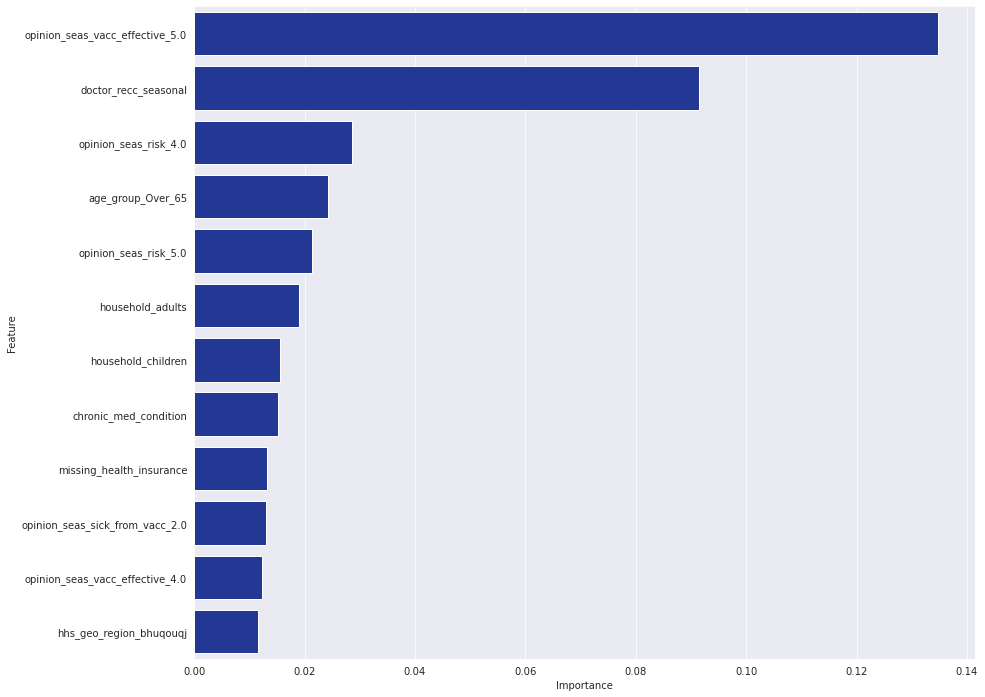

In [23]:
# Feature importance Graph
pal = sns.color_palette(("#102CA8",))
show_feature_importances(dt1, interactions.get_X_train(), figsize=(14, 12), palette=pal, font_scale=1, ascending=False, rows=12, style="darkgrid")


## Determine Ideal Depth

[0.6776971682658554, 0.721226304703955, 0.726421717762696, 0.7310554645448162, 0.7479054528434356, 0.7511350339340043, 0.756704891177159, 0.753007254856073, 0.7494500351041422]


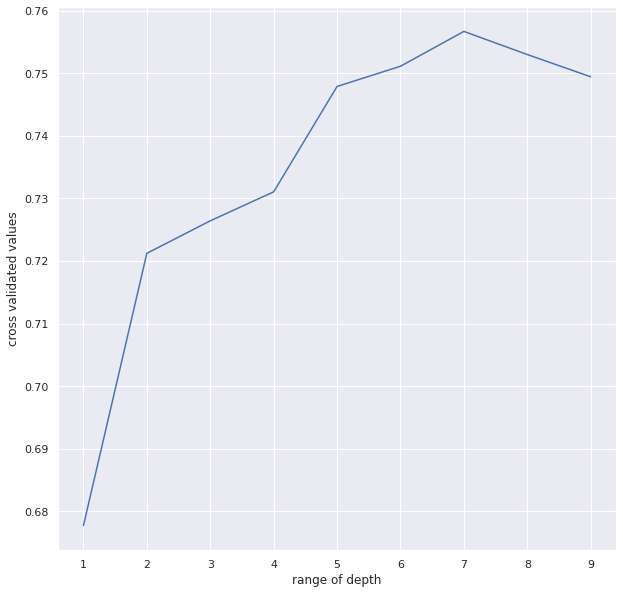

In [25]:
score = cross_val_score(dt1, interactions.get_X_train(), interactions.y_train, cv = 5)
score.mean()
depth_range = range(1,10)
val = []
for depth in depth_range:
    ctree = DecisionTreeClassifier(max_depth = depth)
    depth_score = cross_val_score(ctree, interactions.get_X_train(), interactions.y_train, cv = 5)
    val.append(depth_score.mean())
print(val)
plt.figure(figsize = (10,10))
plt.plot(depth_range, val)
plt.xlabel('range of depth')
plt.ylabel('cross validated values')
plt.show()

## Optimized Decision Tree: Depth 7

In [26]:
# Instantiate and fit a DecisionTreeClassifier
dt2 = DecisionTreeClassifier(criterion='gini', max_depth=7)

# fit the model
dt2.fit(interactions.get_X_train(), interactions.y_train)

evaluate_to_df(dt2, interactions.get_X_test(), interactions.y_test, evaluation, 'Decision Tree-2', 'Optimized: Depth 7')

Decision Tree-2: Optimized: Depth 7
Confusion Matrix :
[[2308  567]
 [ 719 1748]]
Test Accuracy Score : 0.7592661924372894
Report : 
              precision    recall  f1-score   support

           0       0.76      0.80      0.78      2875
           1       0.76      0.71      0.73      2467

    accuracy                           0.76      5342
   macro avg       0.76      0.76      0.76      5342
weighted avg       0.76      0.76      0.76      5342



,Model,Details,Accuracy,Precision,FP,Recall,FN,F1-Score,AUC
1,Logistic Regression-2,"All Features, Scaled",0.793,0.790,494.0,0.751,614.0,0.790,0.770
0,Logistic Regression-1,"All Features, Not Scaled",0.792,0.790,491.0,0.749,618.0,0.789,0.769
3,Logistic Regression-4,"All Features, Scaled, with Interactions",0.791,0.788,495.0,0.747,624.0,0.787,0.767
7,Decision Tree-2,Optimized: Depth 7,0.759,0.755,567.0,0.709,719.0,0.756,0.731
5,K-Nearest Neighbor,Optimized K=9,0.727,0.722,630.0,0.664,829.0,0.722,0.692
4,K-Nearest Neighbor,Baseline K=1,0.709,0.695,712.0,0.658,844.0,0.705,0.676
6,Decision Tree-1,Baseline,0.688,0.661,843.0,0.665,826.0,0.686,0.663
2,Logistic Regression-3,"Select Features, Scaled",0.636,0.633,722.0,0.505,1220.0,0.627,0.562


## Decision Tree: Depth 7 with Reduced Features

In [27]:

dt3 = DecisionTreeClassifier(criterion='gini', max_depth=7)

# fit the model
dt3.fit(reduced.get_X_train(), reduced.y_train)

evaluate_to_df(dt3, reduced.get_X_test(), reduced.y_test, evaluation, 'Decision Tree-3', 'Depth 7, Select Features')

Decision Tree-3: Depth 7, Select Features
Confusion Matrix :
[[2346  529]
 [ 763 1704]]
Test Accuracy Score : 0.7581430175964058
Report : 
              precision    recall  f1-score   support

           0       0.75      0.82      0.78      2875
           1       0.76      0.69      0.73      2467

    accuracy                           0.76      5342
   macro avg       0.76      0.75      0.75      5342
weighted avg       0.76      0.76      0.76      5342



,Model,Details,Accuracy,Precision,FP,Recall,FN,F1-Score,AUC
1,Logistic Regression-2,"All Features, Scaled",0.793,0.790,494.0,0.751,614.0,0.790,0.770
0,Logistic Regression-1,"All Features, Not Scaled",0.792,0.790,491.0,0.749,618.0,0.789,0.769
3,Logistic Regression-4,"All Features, Scaled, with Interactions",0.791,0.788,495.0,0.747,624.0,0.787,0.767
7,Decision Tree-2,Optimized: Depth 7,0.759,0.755,567.0,0.709,719.0,0.756,0.731
8,Decision Tree-3,"Depth 7, Select Features",0.758,0.763,529.0,0.691,763.0,0.753,0.725
5,K-Nearest Neighbor,Optimized K=9,0.727,0.722,630.0,0.664,829.0,0.722,0.692
4,K-Nearest Neighbor,Baseline K=1,0.709,0.695,712.0,0.658,844.0,0.705,0.676
6,Decision Tree-1,Baseline,0.688,0.661,843.0,0.665,826.0,0.686,0.663
2,Logistic Regression-3,"Select Features, Scaled",0.636,0.633,722.0,0.505,1220.0,0.627,0.562


# <span id="5"></span>5. Random Forest
#### [Return Contents](#0)
<hr/>

## Baseline Random Forest

In [28]:
forest1 = RandomForestClassifier(n_estimators=100, max_depth= 5)
forest1.fit(interactions.get_X_train(), interactions.y_train)

evaluate_to_df(forest1, interactions.get_X_test(), interactions.y_test, evaluation, 'Random Forest-1', '100 Est, Max Depth 5')

Random Forest-1: 100 Est, Max Depth 5
Confusion Matrix :
[[2388  487]
 [ 768 1699]]
Test Accuracy Score : 0.7650692624485211
Report : 
              precision    recall  f1-score   support

           0       0.76      0.83      0.79      2875
           1       0.78      0.69      0.73      2467

    accuracy                           0.77      5342
   macro avg       0.77      0.76      0.76      5342
weighted avg       0.77      0.77      0.76      5342



,Model,Details,Accuracy,Precision,FP,Recall,FN,F1-Score,AUC
1,Logistic Regression-2,"All Features, Scaled",0.793,0.790,494.0,0.751,614.0,0.790,0.770
0,Logistic Regression-1,"All Features, Not Scaled",0.792,0.790,491.0,0.749,618.0,0.789,0.769
3,Logistic Regression-4,"All Features, Scaled, with Interactions",0.791,0.788,495.0,0.747,624.0,0.787,0.767
7,Decision Tree-2,Optimized: Depth 7,0.759,0.755,567.0,0.709,719.0,0.756,0.731
9,Random Forest-1,"100 Est, Max Depth 5",0.765,0.777,487.0,0.689,768.0,0.760,0.730
8,Decision Tree-3,"Depth 7, Select Features",0.758,0.763,529.0,0.691,763.0,0.753,0.725
5,K-Nearest Neighbor,Optimized K=9,0.727,0.722,630.0,0.664,829.0,0.722,0.692
4,K-Nearest Neighbor,Baseline K=1,0.709,0.695,712.0,0.658,844.0,0.705,0.676
6,Decision Tree-1,Baseline,0.688,0.661,843.0,0.665,826.0,0.686,0.663
2,Logistic Regression-3,"Select Features, Scaled",0.636,0.633,722.0,0.505,1220.0,0.627,0.562


## Random Forest Optimization: GridSearch

In [29]:
param_grid = {
    'n_estimators': [10, 30, 100],
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 2, 6, 10],
    'min_samples_split': [ 2, 5, 10],
    'min_samples_leaf': [2, 3, 5, 7]
}

#Instantiate the gridsearch object
rf_grid_search = GridSearchCV(forest1, param_grid, cv=3)

# Fit to the data
rf_grid_search.fit(interactions.get_X_train(), interactions.y_train)

GridSearchCV(cv=3, estimator=RandomForestClassifier(max_depth=5),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 2, 6, 10],
                         'min_samples_leaf': [2, 3, 5, 7],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [10, 30, 100]})

In [30]:
rf_grid_search.best_params_

{'criterion': 'gini',
 'max_depth': None,
 'min_samples_leaf': 2,
 'min_samples_split': 5,
 'n_estimators': 100}

## Optimized Random Forest

In [31]:
forest2 = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=2,
                                              min_samples_split=5,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False)
forest2.fit(interactions.get_X_train(), interactions.y_train)

evaluate_to_df(forest2, interactions.get_X_test(), interactions.y_test, evaluation, 'Random Forest-2', 'Optimized Hyperparameters')

Random Forest-2: Optimized Hyperparameters
Confusion Matrix :
[[2328  547]
 [ 609 1858]]
Test Accuracy Score : 0.7836016473231
Report : 
              precision    recall  f1-score   support

           0       0.79      0.81      0.80      2875
           1       0.77      0.75      0.76      2467

    accuracy                           0.78      5342
   macro avg       0.78      0.78      0.78      5342
weighted avg       0.78      0.78      0.78      5342



,Model,Details,Accuracy,Precision,FP,Recall,FN,F1-Score,AUC
1,Logistic Regression-2,"All Features, Scaled",0.793,0.790,494.0,0.751,614.0,0.790,0.770
0,Logistic Regression-1,"All Features, Not Scaled",0.792,0.790,491.0,0.749,618.0,0.789,0.769
3,Logistic Regression-4,"All Features, Scaled, with Interactions",0.791,0.788,495.0,0.747,624.0,0.787,0.767
10,Random Forest-2,Optimized Hyperparameters,0.784,0.773,547.0,0.753,609.0,0.781,0.763
7,Decision Tree-2,Optimized: Depth 7,0.759,0.755,567.0,0.709,719.0,0.756,0.731
9,Random Forest-1,"100 Est, Max Depth 5",0.765,0.777,487.0,0.689,768.0,0.760,0.730
8,Decision Tree-3,"Depth 7, Select Features",0.758,0.763,529.0,0.691,763.0,0.753,0.725
5,K-Nearest Neighbor,Optimized K=9,0.727,0.722,630.0,0.664,829.0,0.722,0.692
4,K-Nearest Neighbor,Baseline K=1,0.709,0.695,712.0,0.658,844.0,0.705,0.676
6,Decision Tree-1,Baseline,0.688,0.661,843.0,0.665,826.0,0.686,0.663


# <span id="6"></span>6. AdaBoost
#### [Return Contents](#0)
<hr/>

## AdaBoost Baseline

In [32]:
adaboost_clf = AdaBoostClassifier(random_state=42)
ada1 = adaboost_clf.fit(interactions.get_X_train(), interactions.y_train)

evaluate_to_df(ada1, interactions.get_X_test(), interactions.y_test, evaluation, 'AdaBoost-1', 'Baseline')

AdaBoost-1: Baseline
Confusion Matrix :
[[2383  492]
 [ 641 1826]]
Test Accuracy Score : 0.7879071508798203
Report : 
              precision    recall  f1-score   support

           0       0.79      0.83      0.81      2875
           1       0.79      0.74      0.76      2467

    accuracy                           0.79      5342
   macro avg       0.79      0.78      0.79      5342
weighted avg       0.79      0.79      0.79      5342



,Model,Details,Accuracy,Precision,FP,Recall,FN,F1-Score,AUC
1,Logistic Regression-2,"All Features, Scaled",0.793,0.790,494.0,0.751,614.0,0.790,0.770
0,Logistic Regression-1,"All Features, Not Scaled",0.792,0.790,491.0,0.749,618.0,0.789,0.769
3,Logistic Regression-4,"All Features, Scaled, with Interactions",0.791,0.788,495.0,0.747,624.0,0.787,0.767
10,Random Forest-2,Optimized Hyperparameters,0.784,0.773,547.0,0.753,609.0,0.781,0.763
11,AdaBoost-1,Baseline,0.788,0.788,492.0,0.740,641.0,0.785,0.763
7,Decision Tree-2,Optimized: Depth 7,0.759,0.755,567.0,0.709,719.0,0.756,0.731
9,Random Forest-1,"100 Est, Max Depth 5",0.765,0.777,487.0,0.689,768.0,0.760,0.730
8,Decision Tree-3,"Depth 7, Select Features",0.758,0.763,529.0,0.691,763.0,0.753,0.725
5,K-Nearest Neighbor,Optimized K=9,0.727,0.722,630.0,0.664,829.0,0.722,0.692
4,K-Nearest Neighbor,Baseline K=1,0.709,0.695,712.0,0.658,844.0,0.705,0.676


## AdaBoost Optimization: GridSearch

In [33]:
param_grid = {
    "learning_rate": [0.1, 0.2],
    'base_estimator': [DecisionTreeClassifier(max_depth=1), DecisionTreeClassifier(max_depth=5)],
    'n_estimators': [5, 30, 100, 250],
}

ada_clf = AdaBoostClassifier(random_state=42)
grid_ada = GridSearchCV(ada_clf, param_grid, scoring='accuracy', cv=None, n_jobs=1)
grid_ada.fit(interactions.get_X_train(), interactions.y_train)

best_parameters = grid_ada.best_params_

print("Grid Search found the following optimal parameters: ")
for param_name in sorted(best_parameters.keys()):
    print("%s: %r" % (param_name, best_parameters[param_name]))

training_preds = grid_ada.predict(interactions.get_X_train())
val_preds = grid_ada.predict(interactions.get_X_test())
training_accuracy = accuracy_score(interactions.y_train, training_preds)
val_accuracy = accuracy_score(interactions.y_test, val_preds)

print("")
print("Training Accuracy: {:.4}%".format(training_accuracy * 100))
print("Validation accuracy: {:.4}%".format(val_accuracy * 100))

Grid Search found the following optimal parameters: 
base_estimator: DecisionTreeClassifier(max_depth=1)
learning_rate: 0.2
n_estimators: 250

Training Accuracy: 77.84%
Validation accuracy: 78.29%


## AdaBoost Optimized

In [34]:
adaboost_clf = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=1, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best'), learning_rate=0.2, n_estimators=250, random_state=42)
ada2 = adaboost_clf.fit(interactions.get_X_train(), interactions.y_train)

evaluate_to_df(ada2, interactions.get_X_test(), interactions.y_test, evaluation, 'AdaBoost-2', 'Optimized')

AdaBoost-2: Optimized
Confusion Matrix :
[[2387  488]
 [ 672 1795]]
Test Accuracy Score : 0.7828528640958442
Report : 
              precision    recall  f1-score   support

           0       0.78      0.83      0.80      2875
           1       0.79      0.73      0.76      2467

    accuracy                           0.78      5342
   macro avg       0.78      0.78      0.78      5342
weighted avg       0.78      0.78      0.78      5342



,Model,Details,Accuracy,Precision,FP,Recall,FN,F1-Score,AUC
1,Logistic Regression-2,"All Features, Scaled",0.793,0.790,494.0,0.751,614.0,0.790,0.770
0,Logistic Regression-1,"All Features, Not Scaled",0.792,0.790,491.0,0.749,618.0,0.789,0.769
3,Logistic Regression-4,"All Features, Scaled, with Interactions",0.791,0.788,495.0,0.747,624.0,0.787,0.767
10,Random Forest-2,Optimized Hyperparameters,0.784,0.773,547.0,0.753,609.0,0.781,0.763
11,AdaBoost-1,Baseline,0.788,0.788,492.0,0.740,641.0,0.785,0.763
12,AdaBoost-2,Optimized,0.783,0.786,488.0,0.728,672.0,0.779,0.756
7,Decision Tree-2,Optimized: Depth 7,0.759,0.755,567.0,0.709,719.0,0.756,0.731
9,Random Forest-1,"100 Est, Max Depth 5",0.765,0.777,487.0,0.689,768.0,0.760,0.730
8,Decision Tree-3,"Depth 7, Select Features",0.758,0.763,529.0,0.691,763.0,0.753,0.725
5,K-Nearest Neighbor,Optimized K=9,0.727,0.722,630.0,0.664,829.0,0.722,0.692


# <span id="7"></span>7. XGBoost
#### [Return Contents](#0)
<hr/>

## XGBoost Baseline

In [35]:
X_train_scaled = interactions.get_X_train().rename(columns=lambda x: x.replace('<', '_'))
X_test_scaled = interactions.get_X_test().rename(columns=lambda x: x.replace('<', '_'))

In [36]:
clf1 = xgb.XGBClassifier()
clf1.fit(X_train_scaled, interactions.y_train)

evaluate_to_df(clf1, X_test_scaled, interactions.y_test, evaluation, 'XGBoosting-1', 'Baseline')

XGBoosting-1: Baseline
Confusion Matrix :
[[2312  563]
 [ 608 1859]]
Test Accuracy Score : 0.7807937102208911
Report : 
              precision    recall  f1-score   support

           0       0.79      0.80      0.80      2875
           1       0.77      0.75      0.76      2467

    accuracy                           0.78      5342
   macro avg       0.78      0.78      0.78      5342
weighted avg       0.78      0.78      0.78      5342



,Model,Details,Accuracy,Precision,FP,Recall,FN,F1-Score,AUC
1,Logistic Regression-2,"All Features, Scaled",0.793,0.790,494.0,0.751,614.0,0.790,0.770
0,Logistic Regression-1,"All Features, Not Scaled",0.792,0.790,491.0,0.749,618.0,0.789,0.769
3,Logistic Regression-4,"All Features, Scaled, with Interactions",0.791,0.788,495.0,0.747,624.0,0.787,0.767
10,Random Forest-2,Optimized Hyperparameters,0.784,0.773,547.0,0.753,609.0,0.781,0.763
11,AdaBoost-1,Baseline,0.788,0.788,492.0,0.740,641.0,0.785,0.763
13,XGBoosting-1,Baseline,0.781,0.768,563.0,0.754,608.0,0.779,0.760
12,AdaBoost-2,Optimized,0.783,0.786,488.0,0.728,672.0,0.779,0.756
7,Decision Tree-2,Optimized: Depth 7,0.759,0.755,567.0,0.709,719.0,0.756,0.731
9,Random Forest-1,"100 Est, Max Depth 5",0.765,0.777,487.0,0.689,768.0,0.760,0.730
8,Decision Tree-3,"Depth 7, Select Features",0.758,0.763,529.0,0.691,763.0,0.753,0.725


## XGBoost Optimization: GridSearch

In [37]:
param_grid = {'n_estimators':[100,300,500],
              'learning_rate':[0.1,0.5,0.01],
              'max_depth':[3,5,7],
              'colsample_bytree':[0.5,0.4,0.3],
              'min_child_weight':[1,2,3]
             }

clf_xg = xgb.XGBClassifier()
grid_clf = GridSearchCV(clf_xg, param_grid, scoring='accuracy', cv=None, n_jobs=1)
grid_clf.fit(X_train_scaled, interactions.y_train)

best_parameters = grid_clf.best_params_

print("Grid Search found the following optimal parameters: ")
for param_name in sorted(best_parameters.keys()):
    print("%s: %r" % (param_name, best_parameters[param_name]))

training_preds = grid_clf.predict(X_train_scaled)
val_preds = grid_clf.predict(X_test_scaled)
training_accuracy = accuracy_score(interactions.y_train, training_preds)
val_accuracy = accuracy_score(interactions.y_test, val_preds)

print("")
print("Training Accuracy: {:.4}%".format(training_accuracy * 100))
print("Validation accuracy: {:.4}%".format(val_accuracy * 100))

Grid Search found the following optimal parameters: 
colsample_bytree: 0.4
learning_rate: 0.1
max_depth: 3
min_child_weight: 1
n_estimators: 300

Training Accuracy: 79.93%
Validation accuracy: 79.31%


## XGBoost Optimized

In [38]:
clf2 = xgb.XGBClassifier(max_depth=3, learning_rate=0.1, n_estimators=300, min_child_weight=1, colsample_bytree=0.4)
clf2.fit(X_train_scaled, interactions.y_train)

evaluate_to_df(clf2, X_test_scaled, interactions.y_test, evaluation, 'XGBoosting-2', 'Optimized')

XGBoosting-2: Optimized
Confusion Matrix :
[[2382  493]
 [ 612 1855]]
Test Accuracy Score : 0.7931486334706103
Report : 
              precision    recall  f1-score   support

           0       0.80      0.83      0.81      2875
           1       0.79      0.75      0.77      2467

    accuracy                           0.79      5342
   macro avg       0.79      0.79      0.79      5342
weighted avg       0.79      0.79      0.79      5342



,Model,Details,Accuracy,Precision,FP,Recall,FN,F1-Score,AUC
14,XGBoosting-2,Optimized,0.793,0.790,493.0,0.752,612.0,0.790,0.771
1,Logistic Regression-2,"All Features, Scaled",0.793,0.790,494.0,0.751,614.0,0.790,0.770
0,Logistic Regression-1,"All Features, Not Scaled",0.792,0.790,491.0,0.749,618.0,0.789,0.769
3,Logistic Regression-4,"All Features, Scaled, with Interactions",0.791,0.788,495.0,0.747,624.0,0.787,0.767
10,Random Forest-2,Optimized Hyperparameters,0.784,0.773,547.0,0.753,609.0,0.781,0.763
11,AdaBoost-1,Baseline,0.788,0.788,492.0,0.740,641.0,0.785,0.763
13,XGBoosting-1,Baseline,0.781,0.768,563.0,0.754,608.0,0.779,0.760
12,AdaBoost-2,Optimized,0.783,0.786,488.0,0.728,672.0,0.779,0.756
7,Decision Tree-2,Optimized: Depth 7,0.759,0.755,567.0,0.709,719.0,0.756,0.731
9,Random Forest-1,"100 Est, Max Depth 5",0.765,0.777,487.0,0.689,768.0,0.760,0.730


# <span id="8"></span>8. Support Vector Machine
#### [Return Contents](#0)
<hr/>

## Support Vector Machine Baseline

In [39]:
svc1 = SVC(kernel='poly', C=.01)  
svc1.fit(interactions.get_X_train(), interactions.y_train) 

evaluate_to_df(svc1, interactions.get_X_test(), interactions.y_test, evaluation, 'SVM', 'Poly, c=.01')

SVM: Poly, c=.01
Confusion Matrix :
[[2870    5]
 [2439   28]]
Test Accuracy Score : 0.5424934481467615
Report : 
              precision    recall  f1-score   support

           0       0.54      1.00      0.70      2875
           1       0.85      0.01      0.02      2467

    accuracy                           0.54      5342
   macro avg       0.69      0.50      0.36      5342
weighted avg       0.68      0.54      0.39      5342



,Model,Details,Accuracy,Precision,FP,Recall,FN,F1-Score,AUC
14,XGBoosting-2,Optimized,0.793,0.790,493.0,0.752,612.0,0.790,0.771
1,Logistic Regression-2,"All Features, Scaled",0.793,0.790,494.0,0.751,614.0,0.790,0.770
0,Logistic Regression-1,"All Features, Not Scaled",0.792,0.790,491.0,0.749,618.0,0.789,0.769
3,Logistic Regression-4,"All Features, Scaled, with Interactions",0.791,0.788,495.0,0.747,624.0,0.787,0.767
10,Random Forest-2,Optimized Hyperparameters,0.784,0.773,547.0,0.753,609.0,0.781,0.763
11,AdaBoost-1,Baseline,0.788,0.788,492.0,0.740,641.0,0.785,0.763
13,XGBoosting-1,Baseline,0.781,0.768,563.0,0.754,608.0,0.779,0.760
12,AdaBoost-2,Optimized,0.783,0.786,488.0,0.728,672.0,0.779,0.756
7,Decision Tree-2,Optimized: Depth 7,0.759,0.755,567.0,0.709,719.0,0.756,0.731
9,Random Forest-1,"100 Est, Max Depth 5",0.765,0.777,487.0,0.689,768.0,0.760,0.730


# <span id="9"></span>9. Best Model
#### [Return Contents](#0)
<hr/>

Based on Accuracy and Area Under the Curve (AUC), our best model appears to be the optimized XG Boost with an accuracy of 0.793, a harmonic F1-Score of .790 and an Area Under the Curve of 0.771.

In [40]:
evaluation.sort_values(by = 'AUC', ascending=False)

,Model,Details,Accuracy,Precision,FP,Recall,FN,F1-Score,AUC
14,XGBoosting-2,Optimized,0.793,0.790,493.0,0.752,612.0,0.790,0.771
1,Logistic Regression-2,"All Features, Scaled",0.793,0.790,494.0,0.751,614.0,0.790,0.770
0,Logistic Regression-1,"All Features, Not Scaled",0.792,0.790,491.0,0.749,618.0,0.789,0.769
3,Logistic Regression-4,"All Features, Scaled, with Interactions",0.791,0.788,495.0,0.747,624.0,0.787,0.767
10,Random Forest-2,Optimized Hyperparameters,0.784,0.773,547.0,0.753,609.0,0.781,0.763
11,AdaBoost-1,Baseline,0.788,0.788,492.0,0.740,641.0,0.785,0.763
13,XGBoosting-1,Baseline,0.781,0.768,563.0,0.754,608.0,0.779,0.760
12,AdaBoost-2,Optimized,0.783,0.786,488.0,0.728,672.0,0.779,0.756
7,Decision Tree-2,Optimized: Depth 7,0.759,0.755,567.0,0.709,719.0,0.756,0.731
9,Random Forest-1,"100 Est, Max Depth 5",0.765,0.777,487.0,0.689,768.0,0.760,0.730


### Logistic Regression Model Analysis

In [41]:
def confusion_matrix_graph(model, X_test, y_test, font_scale=2, style="darkgrid", palette=None, figsize=(14, 12)):
    sns.set_style(style)
    sns.set(font_scale=font_scale)
    f, ax = plt.subplots(figsize=figsize)
    converted_pal = matplotlib.colors.ListedColormap(sns.color_palette(palette))
    plot_confusion_matrix(model, X_test, y_test, cmap=converted_pal, ax=ax)
    for text in ax.texts:
        label = text.get_text()
        label = int(float(label))
        text.set_text(f"{label}")
    plt.show()

Logisitic Regression 2: All Features, Scaled
Confusion Matrix :
[[2382  493]
 [ 612 1855]]
Test Accuracy Score : 0.7931486334706103
Report : 
              precision    recall  f1-score   support

           0       0.80      0.83      0.81      2875
           1       0.79      0.75      0.77      2467

    accuracy                           0.79      5342
   macro avg       0.79      0.79      0.79      5342
weighted avg       0.79      0.79      0.79      5342



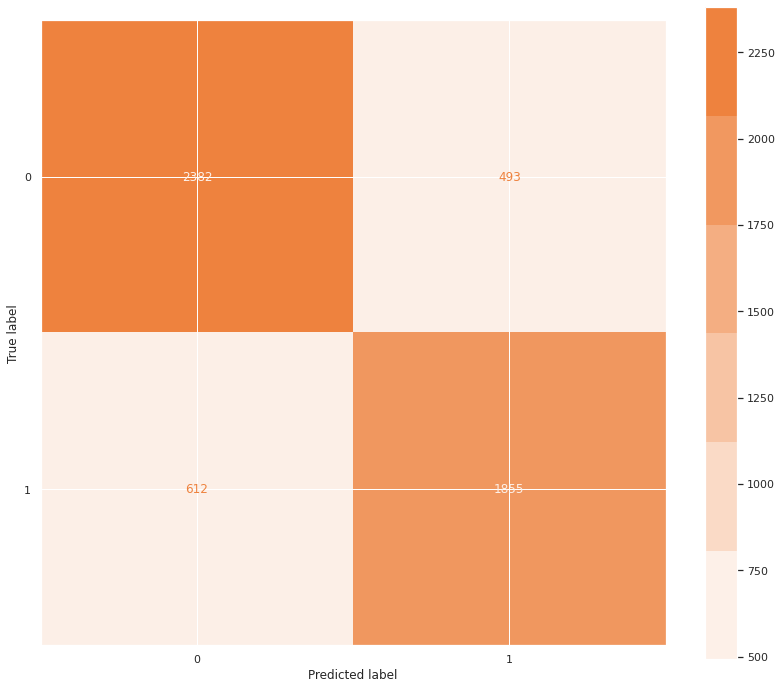

In [44]:
#XG Boost: Select Features, Scaled, with Interactions optimized hyperparameters
xgb_pred1 = clf2.predict(X_test_scaled)

cm = metrics.confusion_matrix(interactions.y_test, xgb_pred1)
print('Logisitic Regression 2: All Features, Scaled')
print('Confusion Matrix :')
print(cm) 
print('Test Accuracy Score :',metrics.accuracy_score(interactions.y_test, xgb_pred1))
print('Report : ')
print(classification_report(interactions.y_test, xgb_pred1))

palette = sns.light_palette("#EE823E")
confusion_matrix_graph(clf2, X_test_scaled, interactions.y_test, font_scale=1, palette=palette, figsize=(14,12))

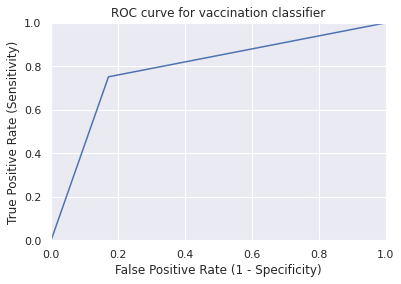

In [46]:
# IMPORTANT: first argument is true values, second argument is predicted probabilities
fpr, tpr, thresholds = metrics.roc_curve(interactions.y_test, xgb_pred1)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve for vaccination classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

### Recommendations

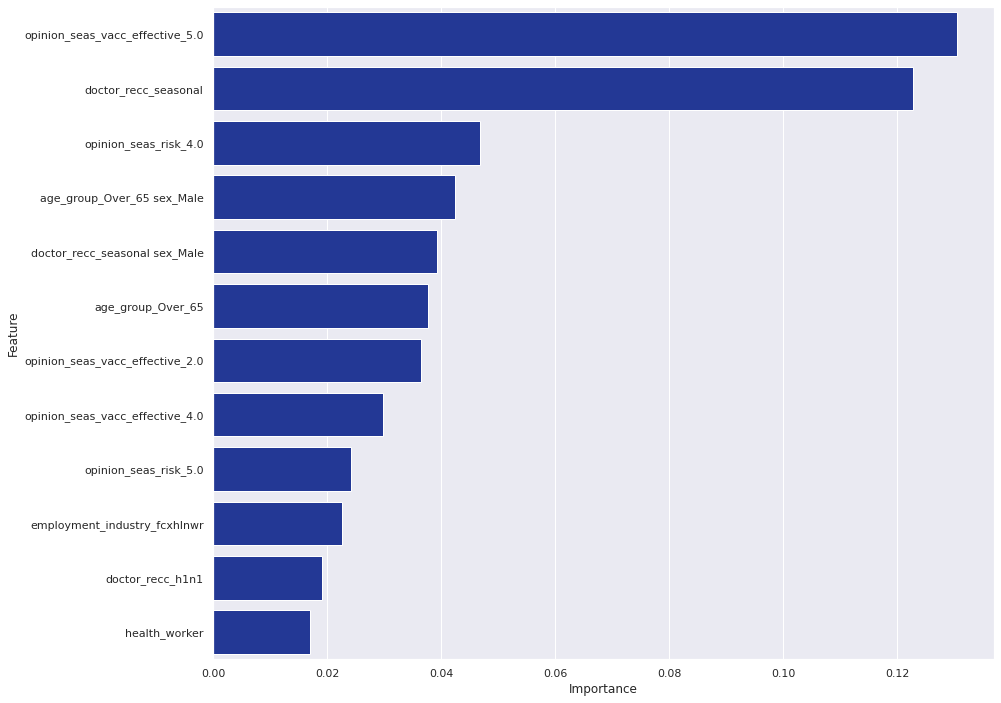

In [47]:
# Feature importance Graph
pal = sns.color_palette(("#102CA8",))
show_feature_importances(clf2, interactions.get_X_train(), figsize=(14, 12), palette=pal, font_scale=1, ascending=False, rows=12, style="darkgrid")

In the the limited adjustment of hyperparameters, the XG boost algorithm created the best performing model. Based on the feature importances, it appears that the strongest factor is a persons strong belief that the vaccine is effective. A doctor's recommendation, being an at risk demographic, or being a healthcare worker also are (not surprisingly) strong factors.